## Hyperparameter Tuning with Keras Tuner

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 6.1 MB/s 


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import kerastuner
    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


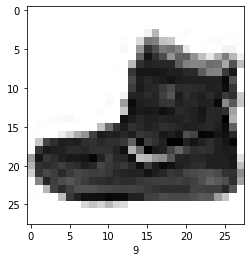

In [ ]:
plt.imshow(x_train[0], cmap='binary')
plt.xlabel(y_train[0])
plt.show()

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
def create_model(hp):
    if hp:
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
        num_units = hp.Choice('num_units', values=[8, 16, 32])
        learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.1)
        num_hidden_layers = hp.Choice('num_hidden_layers', values=[1, 2, 3])
    else:
        dropout_rate = 0.1
        num_units = 8
        learning_rate = 1e-4
        num_hidden_layers = 1
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Lambda(lambda x: x/255.))
    
    for _ in range(0, num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_units, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
        return super(CustomTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=3,
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True,
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': None}
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}


In [ ]:
tuner.search(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5, verbose=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(1)

Results summary
Results in logs/fashion_mnist
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_rate: 0.2542890749315324
num_units: 8
learning_rate: 0.007830650921161766
num_hidden_layers: 1
batch_size: 32
Score: 0.4381999969482422


In [ ]:
model = tuner.get_best_models(num_models=1)[0]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, verbose=2,
    batch_size=32,#Enter Batch Size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/20
1875/1875 - 4s - loss: 1.6484 - accuracy: 0.3359 - val_loss: 1.4121 - val_accuracy: 0.4327 - 4s/epoch - 2ms/step
Epoch 2/20
1875/1875 - 4s - loss: 1.6300 - accuracy: 0.3467 - val_loss: 1.4336 - val_accuracy: 0.4226 - 4s/epoch - 2ms/step
Epoch 3/20
1875/1875 - 4s - loss: 1.6405 - accuracy: 0.3422 - val_loss: 1.4051 - val_accuracy: 0.4277 - 4s/epoch - 2ms/step
Epoch 4/20
1875/1875 - 4s - loss: 1.6295 - accuracy: 0.3477 - val_loss: 1.4148 - val_accuracy: 0.4459 - 4s/epoch - 2ms/step
Epoch 5/20
1875/1875 - 4s - loss: 1.6278 - accuracy: 0.3478 - val_loss: 1.4054 - val_accuracy: 0.4340 - 4s/epoch - 2ms/step
Epoch 6/20
1875/1875 - 4s - loss: 1.6310 - accuracy: 0.3483 - val_loss: 1.4084 - val_accuracy: 0.4436 - 4s/epoch - 2ms/step
Epoch 7/20
1875/1875 - 4s - loss: 1.6346 - accuracy: 0.3440 - val_loss: 1.4078 - val_accuracy: 0.4427 - 4s/epoch - 2ms/step


In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.4078 - accuracy: 0.4427


[1.407832384109497, 0.44269999861717224]